# Import libraries

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# import config
import json
import numpy as np
from shapely.geometry import LineString, mapping
from itertools import combinations
import re
from scipy import spatial

from load_preprocess.functions import Data
from load_preprocess.predictions import Number_Stations
from station_finder.functions import StationLocator, Scenarios
from competitive_analysis.competitive_analysis import Competition_Scenarios


# Load Data

In [172]:
config_path = 'params/config.json'
conf = json.load(open(config_path, "r"))

data = Data(path = 'data/')
df = data.create_df()

df.head(10)

100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


,region,road_density,length_m,area_m,length_max,length_mean,diameter,longest_line
3,Île-de-France,0.000227,2.744410e+06,1.206353e+10,85932.399845,3076.692877,123934.499714,162432.991960
15,Nord-Pas-de-Calais,0.000151,1.887368e+06,1.249483e+10,147881.271737,4015.676440,126130.541927,208410.677869
10,Haute-Normandie,0.000113,1.398489e+06,1.237197e+10,135138.054662,4994.602982,125508.904876,163440.964713
0,Alsace,0.000106,8.836421e+05,8.322648e+09,171172.687144,4374.466068,102940.396161,188809.381774
17,Picardie,0.000093,1.822331e+06,1.954720e+10,163238.986421,7854.875311,157760.172316,218702.689596
20,Rhône-Alpes,0.000090,4.039422e+06,4.497380e+10,203474.560283,4047.517513,239295.676544,319508.048270
13,Lorraine,0.000085,2.007468e+06,2.366142e+10,189457.934215,4562.427574,173570.336256,235280.099059
6,Bretagne,0.000085,2.333729e+06,2.760417e+10,244626.451176,4037.593151,187474.602114,285248.867037
4,Basse-Normandie,0.000078,1.386823e+06,1.780635e+10,122829.920651,3688.358818,150571.399619,263736.945386
16,Pays de la Loire,0.000077,2.480511e+06,3.233398e+10,228887.324618,6852.239326,202901.214557,276408.162313


# Part 1: Determine the number of stations per region

## Scenario 1
### Meet all the demand in 2030 and all the demand in 2040

In [4]:
stations_num_1 = Number_Stations(df_data=df, path_conf='params/config.json', length_to_use='longest_line', scenario="scenario1")
df_f_1 = stations_num_1.final_station_calculation()
df_f_1.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'data/road_go_na_ru3g_spreadsheet.xlsx'

In [4]:
print(f"For scenario 1: {df_f_1.num_stations_2030.sum()} stations are needed by 2030 and {df_f_1.num_stations_2040.sum()} stations are needed by 2040 \n")
stations_num_1.save_predictions(df_f_1)
stations_num_1.get_scenario_output(df_f_1)

For scenario 1: 61 stations are needed by 2030 and 307 stations are needed by 2040 

The output for scenario1 is 61 for 2030 and 307 for 2040.
Region Île-de-France: 4 stations for 2030 and 19 for 2040
Region Nord-Pas-de-Calais: 3 stations for 2030 and 16 for 2040
Region Haute-Normandie: 2 stations for 2030 and 8 for 2040
Region Alsace: 1 stations for 2030 and 7 for 2040
Region Picardie: 2 stations for 2030 and 10 for 2040
Region Rhône-Alpes: 9 stations for 2030 and 43 for 2040
Region Lorraine: 2 stations for 2030 and 8 for 2040
Region Bretagne: 4 stations for 2030 and 22 for 2040
Region Basse-Normandie: 2 stations for 2030 and 8 for 2040
Region Pays de la Loire: 5 stations for 2030 and 26 for 2040
Region Champagne-Ardenne: 2 stations for 2030 and 12 for 2040
Region Provence-Alpes-Côte d'Azur: 4 stations for 2030 and 21 for 2040
Region Poitou-Charentes: 2 stations for 2030 and 12 for 2040
Region Languedoc-Roussillon: 3 stations for 2030 and 13 for 2040
Region Franche-Comté: 1 stations f

## Scenario 2
### Meet 60% of the 2030 demand and 80% of the 2040 demand

In [5]:
stations_num_2 = Number_Stations(df_data=df, path_conf='params/config.json', length_to_use='longest_line', scenario="scenario2")
df_f_2 = stations_num_2.final_station_calculation()
df_f_2.head(10)

,region,road_density,length_m,area_m,length_max,length_mean,diameter,longest_line,perc_load,max_length_drive,...,R_2030_total,C_2030,h2_num_2040,R_2040_high_aut,R_2040_mid_aut,R_2040_low_aut,R_2040_total,C_2040,num_stations_2030,num_stations_2040
0,Île-de-France,0.000227,2.744410e+06,1.206353e+10,85.932400,3.076693,123.934500,162.432992,0.097211,720,...,126.362014,56.451613,4666.140898,250.118625,666.983000,93.794484,1010.896109,56.451613,2,18
1,Nord-Pas-de-Calais,0.000151,1.887368e+06,1.249483e+10,147.881272,4.015676,126.130542,208.410678,0.066784,720,...,111.383339,56.451613,3205.647925,220.470115,587.920306,82.676293,891.066714,56.451613,2,16
2,Haute-Normandie,0.000113,1.398489e+06,1.237197e+10,135.138055,4.994603,125.508905,163.440965,0.039934,720,...,52.230764,56.451613,1916.818598,103.384605,275.692279,38.769227,417.846111,56.451613,1,7
3,Alsace,0.000106,8.836421e+05,8.322648e+09,171.172687,4.374466,102.940396,188.809382,0.029967,720,...,45.278462,56.451613,1438.413183,89.623348,238.995595,33.608756,362.227699,56.451613,1,6
4,Picardie,0.000093,1.822331e+06,1.954720e+10,163.238986,7.854875,157.760172,218.702690,0.040049,720,...,70.092816,56.451613,1922.360954,138.740419,369.974450,52.027657,560.742525,56.451613,1,10
5,Rhône-Alpes,0.000090,4.039422e+06,4.497380e+10,203.474560,4.047518,239.295677,319.508048,0.113242,720,...,289.545152,56.451613,5435.632046,573.120301,1528.320804,214.920113,2316.361218,56.451613,5,41
6,Lorraine,0.000085,2.007468e+06,2.366142e+10,189.457934,4.562428,173.570336,235.280099,0.030442,720,...,57.316261,56.451613,1461.195105,113.450743,302.535314,42.544028,458.530085,56.451613,1,8
7,Bretagne,0.000085,2.333729e+06,2.760417e+10,244.626451,4.037593,187.474602,285.248867,0.066443,720,...,151.670220,56.451613,3189.274819,300.213220,800.568585,112.579957,1213.361762,56.451613,3,21
8,Basse-Normandie,0.000078,1.386823e+06,1.780635e+10,122.829921,3.688359,150.571400,263.736945,0.024451,720,...,51.605262,56.451613,1173.649907,102.146498,272.390660,38.304937,412.842095,56.451613,1,7
9,Pays de la Loire,0.000077,2.480511e+06,3.233398e+10,228.887325,6.852239,202.901215,276.408162,0.078611,720,...,173.884814,56.451613,3773.343533,344.184374,917.824998,129.069140,1391.078512,56.451613,3,25


In [6]:
print(f"For scenario 2: {df_f_2.num_stations_2030.sum()} stations are needed by 2030 and {df_f_2.num_stations_2040.sum()} stations are needed by 2040 \n")
stations_num_2.save_predictions(df_f_2)
stations_num_2.get_scenario_output(df_f_2)

For scenario 2: 37 stations are needed by 2030 and 293 stations are needed by 2040 

The output for scenario2 is 37 for 2030 and 293 for 2040.
Region Île-de-France: 2 stations for 2030 and 18 for 2040
Region Nord-Pas-de-Calais: 2 stations for 2030 and 16 for 2040
Region Haute-Normandie: 1 stations for 2030 and 7 for 2040
Region Alsace: 1 stations for 2030 and 6 for 2040
Region Picardie: 1 stations for 2030 and 10 for 2040
Region Rhône-Alpes: 5 stations for 2030 and 41 for 2040
Region Lorraine: 1 stations for 2030 and 8 for 2040
Region Bretagne: 3 stations for 2030 and 21 for 2040
Region Basse-Normandie: 1 stations for 2030 and 7 for 2040
Region Pays de la Loire: 3 stations for 2030 and 25 for 2040
Region Champagne-Ardenne: 1 stations for 2030 and 12 for 2040
Region Provence-Alpes-Côte d'Azur: 3 stations for 2030 and 20 for 2040
Region Poitou-Charentes: 1 stations for 2030 and 11 for 2040
Region Languedoc-Roussillon: 2 stations for 2030 and 12 for 2040
Region Franche-Comté: 1 stations f

## Scenario 3
### Meet 150% of the 2030 demand and 90% of the 2040 demand

In [7]:
stations_num_3 = Number_Stations(df_data=df, path_conf='params/config.json', length_to_use='longest_line', scenario="scenario3")
df_f_3 = stations_num_3.final_station_calculation()
df_f_3.head(10)

,region,road_density,length_m,area_m,length_max,length_mean,diameter,longest_line,perc_load,max_length_drive,...,R_2030_total,C_2030,h2_num_2040,R_2040_high_aut,R_2040_mid_aut,R_2040_low_aut,R_2040_total,C_2040,num_stations_2030,num_stations_2040
0,Île-de-France,0.000227,2.744410e+06,1.206353e+10,85.932400,3.076693,123.934500,162.432992,0.097211,720,...,315.905034,56.451613,4374.507092,234.486211,625.296562,87.932329,947.715102,56.451613,6,17
1,Nord-Pas-de-Calais,0.000151,1.887368e+06,1.249483e+10,147.881272,4.015676,126.130542,208.410678,0.066784,720,...,278.458348,56.451613,3005.294929,206.690733,551.175287,77.509025,835.375044,56.451613,5,15
2,Haute-Normandie,0.000113,1.398489e+06,1.237197e+10,135.138055,4.994603,125.508905,163.440965,0.039934,720,...,130.576910,56.451613,1797.017436,96.923067,258.461512,36.346150,391.730729,56.451613,2,7
3,Alsace,0.000106,8.836421e+05,8.322648e+09,171.172687,4.374466,102.940396,188.809382,0.029967,720,...,113.196156,56.451613,1348.512359,84.021889,224.058371,31.508208,339.588468,56.451613,2,6
4,Picardie,0.000093,1.822331e+06,1.954720e+10,163.238986,7.854875,157.760172,218.702690,0.040049,720,...,175.232039,56.451613,1802.213394,130.069142,346.851047,48.775928,525.696117,56.451613,3,9
5,Rhône-Alpes,0.000090,4.039422e+06,4.497380e+10,203.474560,4.047518,239.295677,319.508048,0.113242,720,...,723.862881,56.451613,5095.905043,537.300283,1432.800754,201.487606,2171.588642,56.451613,13,38
6,Lorraine,0.000085,2.007468e+06,2.366142e+10,189.457934,4.562428,173.570336,235.280099,0.030442,720,...,143.290651,56.451613,1369.870411,106.360071,283.626856,39.885027,429.871954,56.451613,3,8
7,Bretagne,0.000085,2.333729e+06,2.760417e+10,244.626451,4.037593,187.474602,285.248867,0.066443,720,...,379.175551,56.451613,2989.945143,281.449893,750.533049,105.543710,1137.526652,56.451613,7,20
8,Basse-Normandie,0.000078,1.386823e+06,1.780635e+10,122.829921,3.688359,150.571400,263.736945,0.024451,720,...,129.013155,56.451613,1100.296787,95.762342,255.366244,35.910878,387.039464,56.451613,2,7
9,Pays de la Loire,0.000077,2.480511e+06,3.233398e+10,228.887325,6.852239,202.901215,276.408162,0.078611,720,...,434.712035,56.451613,3537.509562,322.672851,860.460935,121.002319,1304.136105,56.451613,8,23


In [8]:
print(f"For scenario 3: {df_f_3.num_stations_2030.sum()} stations are needed by 2030 and {df_f_3.num_stations_2040.sum()} stations are needed by 2040 \n")
stations_num_3.save_predictions(df_f_3)
stations_num_3.get_scenario_output(df_f_3)

For scenario 3: 93 stations are needed by 2030 and 276 stations are needed by 2040 

The output for scenario3 is 93 for 2030 and 276 for 2040.
Region Île-de-France: 6 stations for 2030 and 17 for 2040
Region Nord-Pas-de-Calais: 5 stations for 2030 and 15 for 2040
Region Haute-Normandie: 2 stations for 2030 and 7 for 2040
Region Alsace: 2 stations for 2030 and 6 for 2040
Region Picardie: 3 stations for 2030 and 9 for 2040
Region Rhône-Alpes: 13 stations for 2030 and 38 for 2040
Region Lorraine: 3 stations for 2030 and 8 for 2040
Region Bretagne: 7 stations for 2030 and 20 for 2040
Region Basse-Normandie: 2 stations for 2030 and 7 for 2040
Region Pays de la Loire: 8 stations for 2030 and 23 for 2040
Region Champagne-Ardenne: 4 stations for 2030 and 11 for 2040
Region Provence-Alpes-Côte d'Azur: 6 stations for 2030 and 19 for 2040
Region Poitou-Charentes: 4 stations for 2030 and 11 for 2040
Region Languedoc-Roussillon: 4 stations for 2030 and 11 for 2040
Region Franche-Comté: 1 stations f

## Scenario 4
### Meet all the demand of 2030 and 2040 with the assumption that there will be 60% of high autonomy trucks, 35% of medium and 5% of low autonomy trucks 

In [9]:
stations_num_4 = Number_Stations(df_data=df, path_conf='params/config.json', length_to_use='longest_line', scenario="scenario4")
df_f_4 = stations_num_4.final_station_calculation()
df_f_4.head(10)

,region,road_density,length_m,area_m,length_max,length_mean,diameter,longest_line,perc_load,max_length_drive,...,R_2030_total,C_2030,h2_num_2040,R_2040_high_aut,R_2040_mid_aut,R_2040_low_aut,R_2040_total,C_2040,num_stations_2030,num_stations_2040
0,Île-de-France,0.000227,2.744410e+06,1.206353e+10,85.932400,3.076693,123.934500,162.432992,0.097211,720,...,245.078882,56.451613,4841.121182,471.814679,733.933945,14.744209,1220.492832,56.451613,4,22
1,Nord-Pas-de-Calais,0.000151,1.887368e+06,1.249483e+10,147.881272,4.015676,126.130542,208.410678,0.066784,720,...,216.027772,56.451613,3325.859722,415.886807,646.935034,12.996463,1075.818304,56.451613,4,19
2,Haute-Normandie,0.000113,1.398489e+06,1.237197e+10,135.138055,4.994603,125.508905,163.440965,0.039934,720,...,101.301466,56.451613,1988.699295,195.020959,303.365936,6.094405,504.481300,56.451613,2,9
3,Alsace,0.000106,8.836421e+05,8.322648e+09,171.172687,4.374466,102.940396,188.809382,0.029967,720,...,87.817491,56.451613,1492.353678,169.062225,262.985684,5.283195,437.331103,56.451613,2,8
4,Picardie,0.000093,1.822331e+06,1.954720e+10,163.238986,7.854875,157.760172,218.702690,0.040049,720,...,135.944881,56.451613,1994.449490,261.714881,407.112037,8.178590,677.005507,56.451613,2,12
5,Rhône-Alpes,0.000090,4.039422e+06,4.497380e+10,203.474560,4.047518,239.295677,319.508048,0.113242,720,...,561.572265,56.451613,5639.468248,1081.113296,1681.731794,33.784790,2796.629880,56.451613,10,50
6,Lorraine,0.000085,2.007468e+06,2.366142e+10,189.457934,4.562428,173.570336,235.280099,0.030442,720,...,111.164777,56.451613,1515.989921,214.009355,332.903442,6.687792,553.600589,56.451613,2,10
7,Bretagne,0.000085,2.333729e+06,2.760417e+10,244.626451,4.037593,187.474602,285.248867,0.066443,720,...,294.164100,56.451613,3308.872625,566.311300,880.928690,17.697228,1464.937218,56.451613,5,26
8,Basse-Normandie,0.000078,1.386823e+06,1.780635e+10,122.829921,3.688359,150.571400,263.736945,0.024451,720,...,100.088306,56.451613,1217.661778,192.685439,299.732905,6.021420,498.439763,56.451613,2,9
9,Pays de la Loire,0.000077,2.480511e+06,3.233398e+10,228.887325,6.852239,202.901215,276.408162,0.078611,720,...,337.249262,56.451613,3914.843916,649.256888,1009.955158,20.289278,1679.501324,56.451613,6,30


In [10]:
print(f"For scenario 4: {df_f_4.num_stations_2030.sum()} stations are needed by 2030 and {df_f_4.num_stations_2040.sum()} stations are needed by 2040 \n")
stations_num_4.save_predictions(df_f_4)
stations_num_4.get_scenario_output(df_f_4)

For scenario 4: 73 stations are needed by 2030 and 358 stations are needed by 2040 

The output for scenario4 is 73 for 2030 and 358 for 2040.
Region Île-de-France: 4 stations for 2030 and 22 for 2040
Region Nord-Pas-de-Calais: 4 stations for 2030 and 19 for 2040
Region Haute-Normandie: 2 stations for 2030 and 9 for 2040
Region Alsace: 2 stations for 2030 and 8 for 2040
Region Picardie: 2 stations for 2030 and 12 for 2040
Region Rhône-Alpes: 10 stations for 2030 and 50 for 2040
Region Lorraine: 2 stations for 2030 and 10 for 2040
Region Bretagne: 5 stations for 2030 and 26 for 2040
Region Basse-Normandie: 2 stations for 2030 and 9 for 2040
Region Pays de la Loire: 6 stations for 2030 and 30 for 2040
Region Champagne-Ardenne: 3 stations for 2030 and 14 for 2040
Region Provence-Alpes-Côte d'Azur: 5 stations for 2030 and 24 for 2040
Region Poitou-Charentes: 3 stations for 2030 and 14 for 2040
Region Languedoc-Roussillon: 3 stations for 2030 and 15 for 2040
Region Franche-Comté: 1 stations

# Part 2: Determine the location and size of the stations

## Load the data

In [173]:
shap_files = data.get_shapefiles()
csvs = data.get_csvs()
jsons = data.get_jsons()

100%|██████████| 10/10 [00:00<00:00, 40.23it/s]


In [11]:
station_locator = StationLocator(shap_files, csvs)
grid_size = conf["grid_size"]

In [174]:
station_locator = StationLocator(shap_files, csvs)
sorted_locations = station_locator.get_best_location(grid_size=8_000)

100%|██████████| 14157/14157 [38:58<00:00,  6.05it/s] 


Get the locations of the stations for each scenario in part 1 by updating the the input to the jsons.

In [175]:
# update jsons inputs based on scenario
scenarios = Scenarios(shap_files, csvs, jsons, path_conf="params/config.json")
region_breakdown = jsons['output_scenario1']["num_stations_2040"] + jsons['output_scenario1']["num_stations_2030"]
top_locations = scenarios.distribute_locations(sorted_locations = sorted_locations,region_breakdown = region_breakdown)
regions_dem = jsons['output_refills_scenario1']["RT_2040_total"] + jsons['output_refills_scenario1']["RT_2030_total"]
top_locations = list(zip(top_locations[0], top_locations[1]))
new_points = scenarios.fix_locations(top_locations)
polygons = scenarios.merge_closest_points(new_points)
polygons = scenarios.fix_locations(polygons)
score_total = sum([score for i, score in top_locations])
final_points = scenarios.get_size_station(regions_dem, polygons, score_total)

100%|██████████| 332/332 [08:06<00:00,  1.46s/it]


In [176]:
# saves a map.html
scenarios.visualize_scenarios(final_points)

# Part 3: Determine the number and location of stations to deploy each year and the profitability.

In [254]:
competition_scenarios = Competition_Scenarios(jsons, path_conf='params/config.json')
scenarios = Scenarios(shap_files, csvs, jsons, path_conf="params/config.json")

## Scenario 1: Air Liquide is the only player in the market

Given that we are the only player in the market and we have a limited investment, we won't be addressing the full demand and thus will go for the worst case scenario.

In [255]:
# update jsons inputs based on scenario and year you want to look at
region_breakdown = jsons['output_scenario2']["num_stations_2040"] + jsons['output_scenario2']["num_stations_2030"]
top_locations = scenarios.distribute_locations(sorted_locations = sorted_locations,region_breakdown = region_breakdown)
regions_dem = jsons['output_refills_scenario2']["RT_2040_total"] + jsons['output_refills_scenario2']["RT_2030_total"]
top_locations = list(zip(top_locations[0], top_locations[1]))
new_points = scenarios.fix_locations(top_locations)
polygons = scenarios.merge_closest_points(new_points)
polygons = scenarios.fix_locations(polygons)
score_total = sum([score for i, score in top_locations])
final_points = scenarios.get_size_station(regions_dem, polygons, score_total)

100%|██████████| 272/272 [06:43<00:00,  1.48s/it]


In [256]:
final_points_scenario1 = competition_scenarios.stations_per_year(final_points, scenario="scenario1")
operation_profit_scenario1 = competition_scenarios.calculate_yearly_op_profit(final_points_scenario1)
cost_yearly_scenario1 = competition_scenarios.get_profitability_by_year(operation_profit_scenario1)
cost_yearly_scenario1

100%|██████████| 260/260 [00:00<00:00, 1356.89it/s]


,year,costs_fix,profit_op_year,max_op_profit,cumsum_maxopprofit,cumsumwithgrowth_profit,total_profit,total_profit_cumsum
0,2030,240.0,21.758282,202.200,202.200,21.758282,-218.241718,-218.241718
1,2031,184.0,14.415811,155.020,357.220,40.438716,-143.561284,-361.803002
2,2032,184.0,16.804063,155.020,512.240,65.168767,-118.831233,-480.634236
3,2033,184.0,19.969518,155.020,667.260,97.911363,-86.088637,-566.722873
4,2034,184.0,23.841523,155.020,822.280,140.943513,-43.056487,-609.779360
5,2035,142.0,30.269557,106.160,928.440,198.837999,56.837999,-552.941361
6,2036,115.0,36.533646,74.750,1003.190,274.343893,159.343893,-393.597468
7,2037,115.0,39.861342,74.750,1077.940,367.976638,252.976638,-140.620830
8,2038,115.0,42.043317,74.750,1152.690,482.143376,367.143376,226.522546
9,2039,77.0,37.227393,41.975,1194.665,613.870870,536.870870,763.393417


Text(0.5, 1.0, 'Number of new operational stations per year')

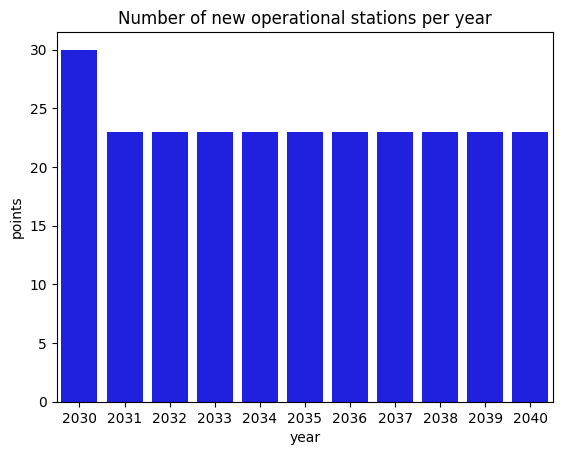

In [257]:
num_stations_per_year = final_points_scenario1.groupby("year")["points"].count().reset_index()
sns.barplot(data=num_stations_per_year, x="year", y="points", color="blue")
plt.title("Number of new operational stations per year")

Air Liquide will be profitable on year 5 and will breakeven on year 8.


<AxesSubplot:xlabel='year', ylabel='cumsumwithgrowth_profit'>

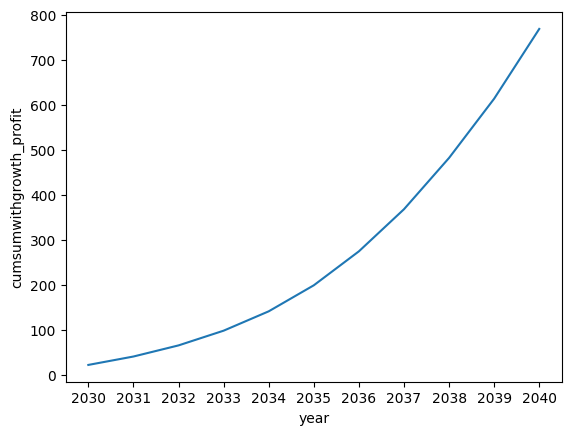

In [258]:
profitable_year = cost_yearly_scenario1["total_profit"].gt(0).idxmax()
breakenven_year = cost_yearly_scenario1["total_profit_cumsum"].gt(0).idxmax()
print(f"Air Liquide will be profitable on year {profitable_year} and will breakeven on year {breakenven_year}.")
sns.lineplot(data=cost_yearly_scenario1, x="year", y="cumsumwithgrowth_profit")

## Scenario 2: Air Liquide and Red Team are entering simultaneously

Given that Air Liquide is entering the market at the same time as Red Team, we assume the Baseline Scenario in part 1 (full demand addressed by the two players).
We assume that both players have the same information on the strategic locations and that they can deploy a fixed number of locations. We identify the locations that both players will go after by 2030 and 2040 based on the profitability score and assign an equal number of stations randomly to each player to mimic "real" competition. We then calculate the operational profitability for each year and the total profitability.

In [259]:
# update jsons inputs based on scenario and year you want to look at
scenarios = Scenarios(shap_files, csvs, jsons, path_conf="params/config.json")
region_breakdown = jsons['output_scenario1']["num_stations_2040"] + jsons['output_scenario1']["num_stations_2030"]
top_locations = scenarios.distribute_locations(sorted_locations = sorted_locations,region_breakdown = region_breakdown)
regions_dem = jsons['output_refills_scenario1']["RT_2040_total"] + jsons['output_refills_scenario1']["RT_2030_total"]
top_locations = list(zip(top_locations[0], top_locations[1]))
new_points = scenarios.fix_locations(top_locations)
polygons = scenarios.merge_closest_points(new_points)
polygons = scenarios.fix_locations(polygons)
score_total = sum([score for i, score in top_locations])
final_points = scenarios.get_size_station(regions_dem, polygons, score_total)

100%|██████████| 332/332 [07:06<00:00,  1.28s/it]


In [260]:
final_points_scenario2 = competition_scenarios.stations_per_year(final_points, scenario="scenario2")
operation_profit_scenario2 = competition_scenarios.calculate_yearly_op_profit(final_points_scenario2)
cost_yearly_scenario2 = competition_scenarios.get_profitability_by_year(operation_profit_scenario2)
cost_yearly_scenario2

100%|██████████| 142/142 [00:00<00:00, 755.82it/s]


,year,costs_fix,profit_op_year,max_op_profit,cumsum_maxopprofit,cumsumwithgrowth_profit,total_profit,total_profit_cumsum
0,2030,176.0,13.393665,148.28,148.28,13.393665,-162.606335,-162.606335
1,2031,96.0,5.898162,80.88,229.16,21.916986,-74.083014,-236.689349
2,2032,96.0,7.135353,80.88,310.04,33.348068,-62.651932,-299.341281
3,2033,93.0,9.027917,77.39,387.43,48.912206,-44.087794,-343.429075
4,2034,60.0,12.573505,39.00,426.43,71.072504,11.072504,-332.356571
5,2035,60.0,14.891525,39.00,465.43,99.894240,39.894240,-292.462332
6,2036,60.0,17.138899,39.00,504.43,136.612409,76.612409,-215.849922
7,2037,60.0,19.179691,39.00,543.43,182.568133,122.568133,-93.281790
8,2038,52.0,20.025707,32.10,575.53,238.377194,186.377194,93.095404
9,2039,36.0,18.272722,18.30,593.83,303.371846,267.371846,360.467250


Text(0.5, 1.0, 'Number of new operational stations per year')

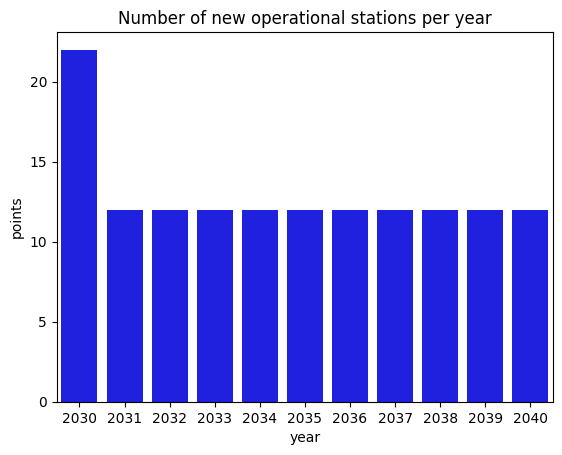

In [261]:
num_stations_per_year = final_points_scenario2.groupby("year")["points"].count().reset_index()
sns.barplot(data=num_stations_per_year, x="year", y="points", color="blue")
plt.title("Number of new operational stations per year")

Air Liquide will be profitable on year 4 and will breakeven on year 8.


<AxesSubplot:xlabel='year', ylabel='cumsumwithgrowth_profit'>

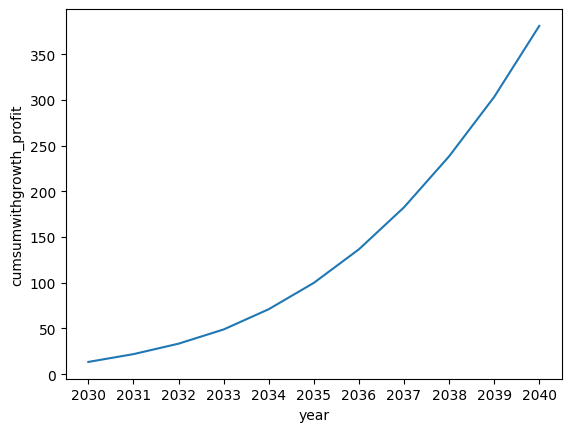

In [262]:
profitable_year = cost_yearly_scenario2["total_profit"].gt(0).idxmax()
breakenven_year = cost_yearly_scenario2["total_profit_cumsum"].gt(0).idxmax()
print(f"Air Liquide will be profitable on year {profitable_year} and will breakeven on year {breakenven_year}.")
sns.lineplot(data=cost_yearly_scenario2, x="year", y="cumsumwithgrowth_profit")

## Scenario 3: Air Liquide enters after Red Team 

In [263]:
from station_finder.functions import Case
import geopandas as gpd

case = Case(shapefiles=shap_files, csvs=csvs, jsons=jsons)
scenarios = Scenarios(shap_files, csvs, jsons, path_conf="params/config.json")
new_scenarios = case.market_share(jsons['output_scenario1'],
                                  sorted_locations,
                                  case.total_h2_stations)

final_points_scenario3 = case.calculate_case3(sorted_locations, scenario=new_scenarios)
regions_dem = jsons['output_refills_scenario1']["RT_2040_total"] + jsons['output_refills_scenario1']["RT_2030_total"]

# apologies for this
ab = final_points_scenario3.copy()
score_total = sum([data[1] for i in ab.values() for data in i if data[1]>0])
df = pd.DataFrame()
for year, data in ab.items():
    foo = gpd.GeoDataFrame(ab[year], geometry=0).set_crs('2154')
    foo = scenarios.fix_locations(foo)
    foo = scenarios.merge_closest_points(foo)
    foo = scenarios.fix_locations(foo)
    #scores = [x[1] for x in foo]
    foo = pd.DataFrame(scenarios.get_size_station(regions_dem, foo, score_total))
    foo['year'] = year
    #foo['weighted_scores'] = scores
    df = pd.concat([df, foo], axis=0)
    
df.rename(columns={0:"points", 1:"size", 2:"score", 3:"2040_demand"}, inplace=True)

100%|██████████| 14157/14157 [04:58<00:00, 47.50it/s]


Calculating year 2031


100%|██████████| 1442/1442 [00:31<00:00, 45.09it/s]


Calculating year 2032


100%|██████████| 1417/1417 [00:35<00:00, 40.43it/s]


Calculating year 2033


100%|██████████| 1391/1391 [00:34<00:00, 40.36it/s]


Calculating year 2034


100%|██████████| 1370/1370 [00:43<00:00, 31.73it/s]


Calculating year 2035


100%|██████████| 1348/1348 [00:39<00:00, 34.52it/s]


Calculating year 2036


100%|██████████| 1323/1323 [00:39<00:00, 33.69it/s]


Calculating year 2037


100%|██████████| 1301/1301 [00:42<00:00, 30.82it/s]


Calculating year 2038


100%|██████████| 1282/1282 [00:43<00:00, 29.30it/s]


Calculating year 2039


100%|██████████| 1263/1263 [00:52<00:00, 24.27it/s]


Calculating year 2040


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Text(0.5, 1.0, 'Number of new operational stations per year')

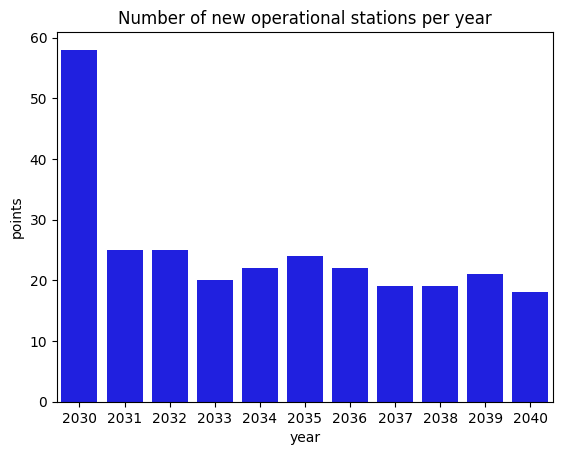

In [264]:
num_stations_per_year = df.groupby("year")["points"].count().reset_index()
sns.barplot(data=num_stations_per_year, x="year", y="points", color="blue")
plt.title("Number of new operational stations per year")


In [265]:
operation_profit_scenario3 = competition_scenarios.calculate_yearly_op_profit(df)
cost_yearly_scenario3 = competition_scenarios.get_profitability_by_year(operation_profit_scenario3)
cost_yearly_scenario3

 26%|██▋       | 72/273 [00:00<00:00, 571.41it/s]


KeyError: ''

Air Liquide will be profitable on year 1 and will breakeven on year 1.


<AxesSubplot:xlabel='year', ylabel='cumsumwithgrowth_profit'>

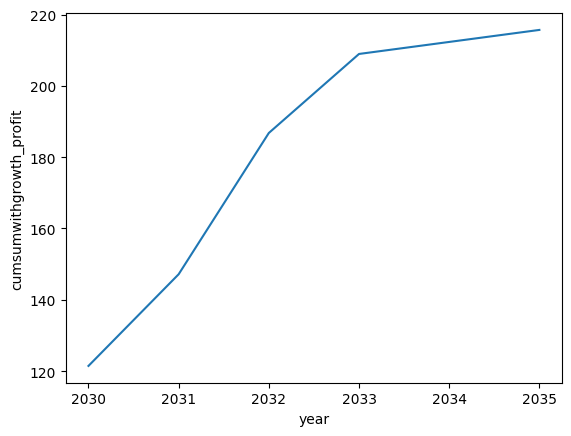

In [11]:
profitable_year = cost_yearly_scenario3["total_profit"].gt(0).idxmax()
breakenven_year = cost_yearly_scenario3["total_profit_cumsum"].gt(0).idxmax()
print(f"Air Liquide will be profitable on year {profitable_year} and will breakeven on year {breakenven_year}.")
sns.lineplot(data=cost_yearly_scenario3, x="year", y="cumsumwithgrowth_profit")

## Part 4: Finding optimal hydrogen locations

In [198]:
# backup csvs for personal use
from shapely.wkt import loads

final_points_scenario1 = pd.read_csv('final_points_scenario1.csv', index_col=0)
final_points_scenario1['points'] = final_points_scenario1['points'].apply(loads)
final_points_scenario2 = pd.read_csv('final_points_scenario2.csv', index_col=0)
final_points_scenario2['points'] = final_points_scenario2['points'].apply(loads)
final_points_scenario3 = pd.read_csv('final_points_scenario3.csv', index_col=0)
final_points_scenario3['points'] = final_points_scenario3['0'].apply(loads)

In [286]:
from IPython import get_ipython
ipython = get_ipython()

ipython.magic("matplotlib inline")
ipython.magic("reload_ext autoreload")
ipython.magic("autoreload 2")

### Optimal locations for Scenario 1

In [287]:
final_points_scenario1['size'] = final_points_scenario1['size'].replace('', np.nan)
final_points_scenario1 = final_points_scenario1.dropna(subset='size')
final_points_scenario1['demand'] = np.where(final_points_scenario1['size'] == 'large', 
                                            4 * 365, 
                                            np.where(final_points_scenario1['size'] == 'medium', 
                                             2 * 365,
                                             1 * 365))
final_points_scenario1 = final_points_scenario1.rename(columns={'points': 0})

100%|██████████| 62/62 [01:02<00:00,  1.01s/it]


Best cluster size is: 18


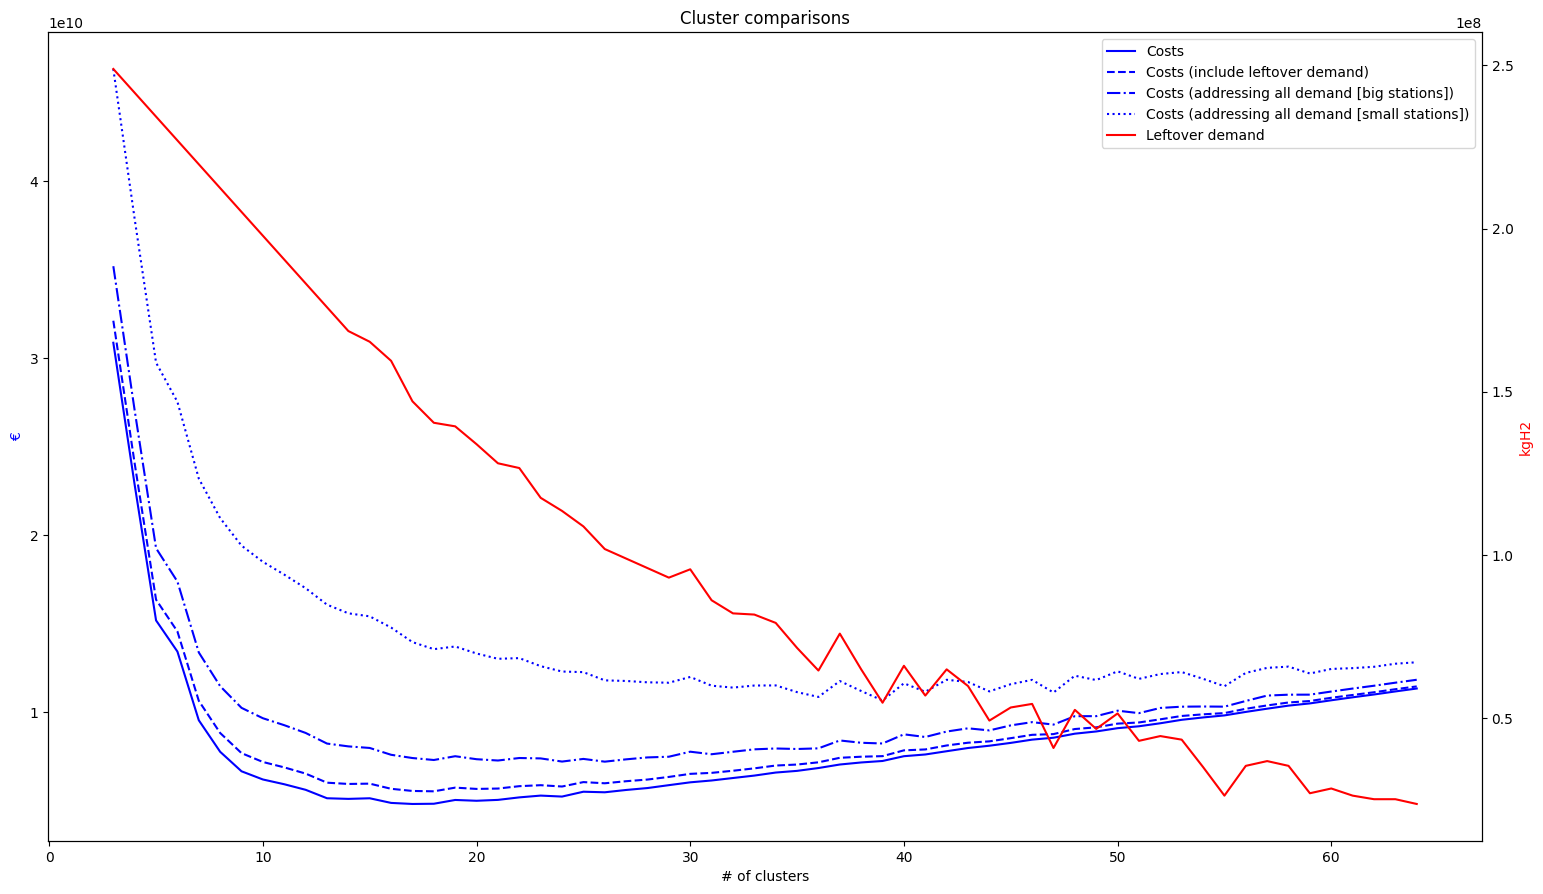

In [305]:
from station_finder.functions import ProductionLocator
plocator = ProductionLocator(shap_files, csvs, jsons, path_conf='params/config.json')
# Iterating over all cluster counts to find amount that would reduce costs the most
plocator.visualize_best_cluster(final_points_scenario1, savefile='plot_scenario1.jpg')

In [311]:
# now we get the locations of the productions sites:
production_sites = plocator.clustering_sites(final_points_scenario1, num_production_sites=18)
result = plocator.find_distance_demand(production_sites, final_points_scenario1) # find distance to nearest production site
cost, leftover, production_info = plocator.get_costs(result)
production_sites_scenario1 = pd.concat([production_info, production_sites], axis=1)

### Optimal locations for Scenario 2

In [268]:
final_points_scenario2['size'] = final_points_scenario2['size'].replace('', np.nan)
final_points_scenario2 = final_points_scenario2.dropna(subset='size')
final_points_scenario2['demand'] = np.where(final_points_scenario2['size'] == 'large', 
                                            4 * 365, 
                                            np.where(final_points_scenario2['size'] == 'medium', 
                                             2 * 365,
                                             1 * 365))
final_points_scenario2 = final_points_scenario2.rename(columns={'points': 0})

100%|██████████| 62/62 [00:45<00:00,  1.36it/s]


Best cluster size is: 13


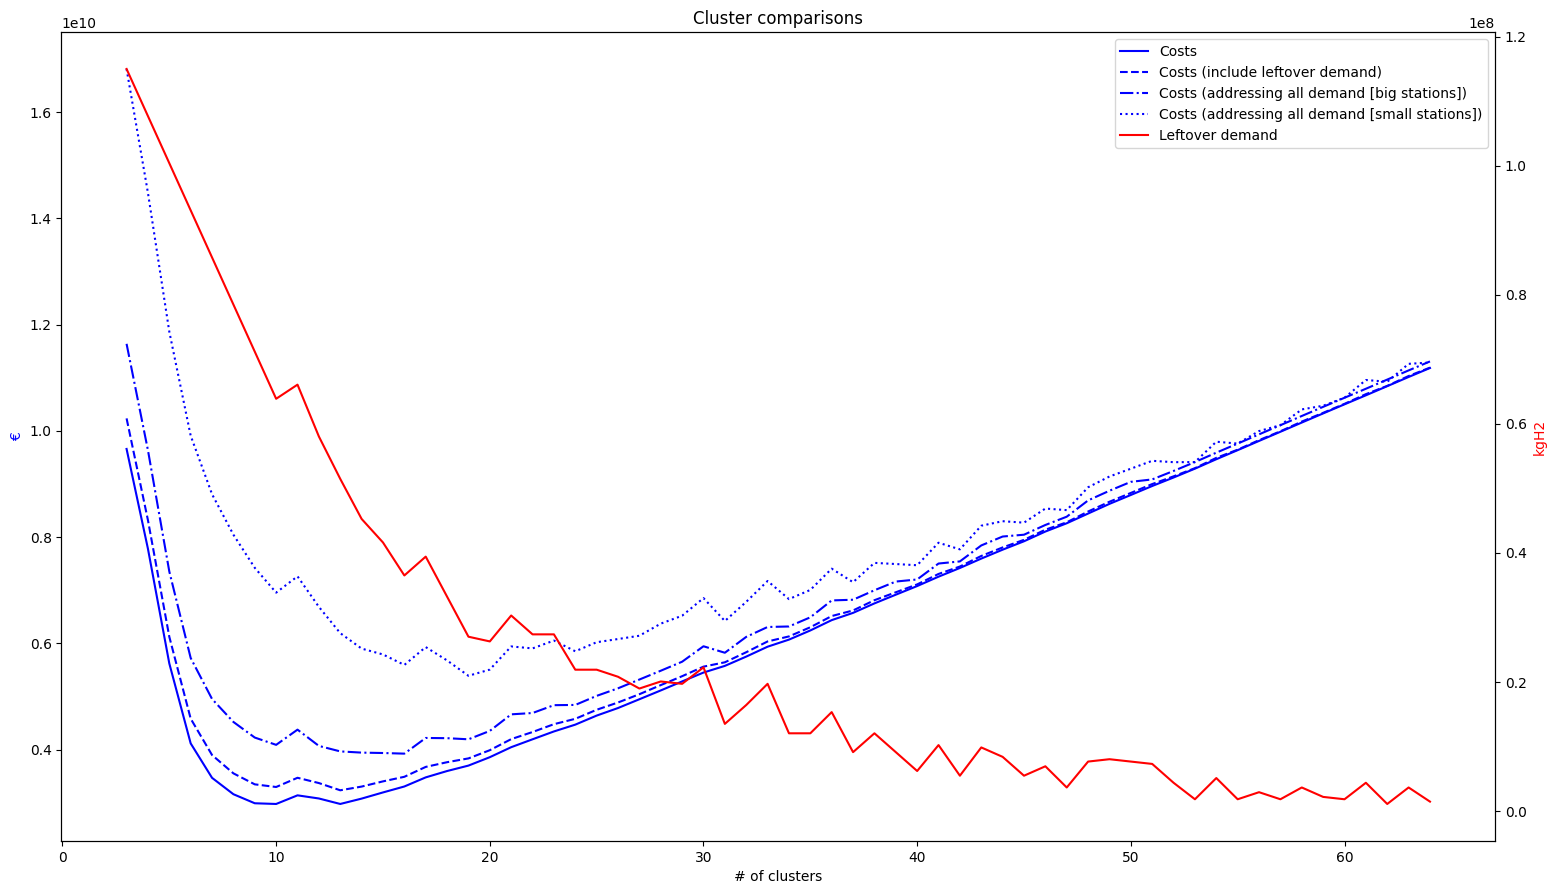

In [306]:
# Iterating over all cluster counts to find amount that would reduce costs the most
plocator.visualize_best_cluster(final_points_scenario2, savefile='plot_scenario2.jpg')

In [312]:
# now we get the locations of the productions sites:
production_sites = plocator.clustering_sites(final_points_scenario1, num_production_sites=13)
result = plocator.find_distance_demand(production_sites, final_points_scenario1) # find distance to nearest production site
cost, leftover, production_info = plocator.get_costs(result)
production_sites_scenario2 = pd.concat([production_info, production_sites], axis=1)

### Optimal locations for Scenario 3

In [273]:
final_points_scenario3 = df

final_points_scenario3['size'] = final_points_scenario3['size'].replace('', np.nan)
final_points_scenario3 = final_points_scenario3.dropna(subset='size')
final_points_scenario3['demand'] = np.where(final_points_scenario3['size'] == 'large', 
                                            4 * 365, 
                                            np.where(final_points_scenario3['size'] == 'medium', 
                                             2 * 365,
                                             1 * 365))
final_points_scenario3 = final_points_scenario3.rename(columns={'points': 0})

100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Best cluster size is: 10


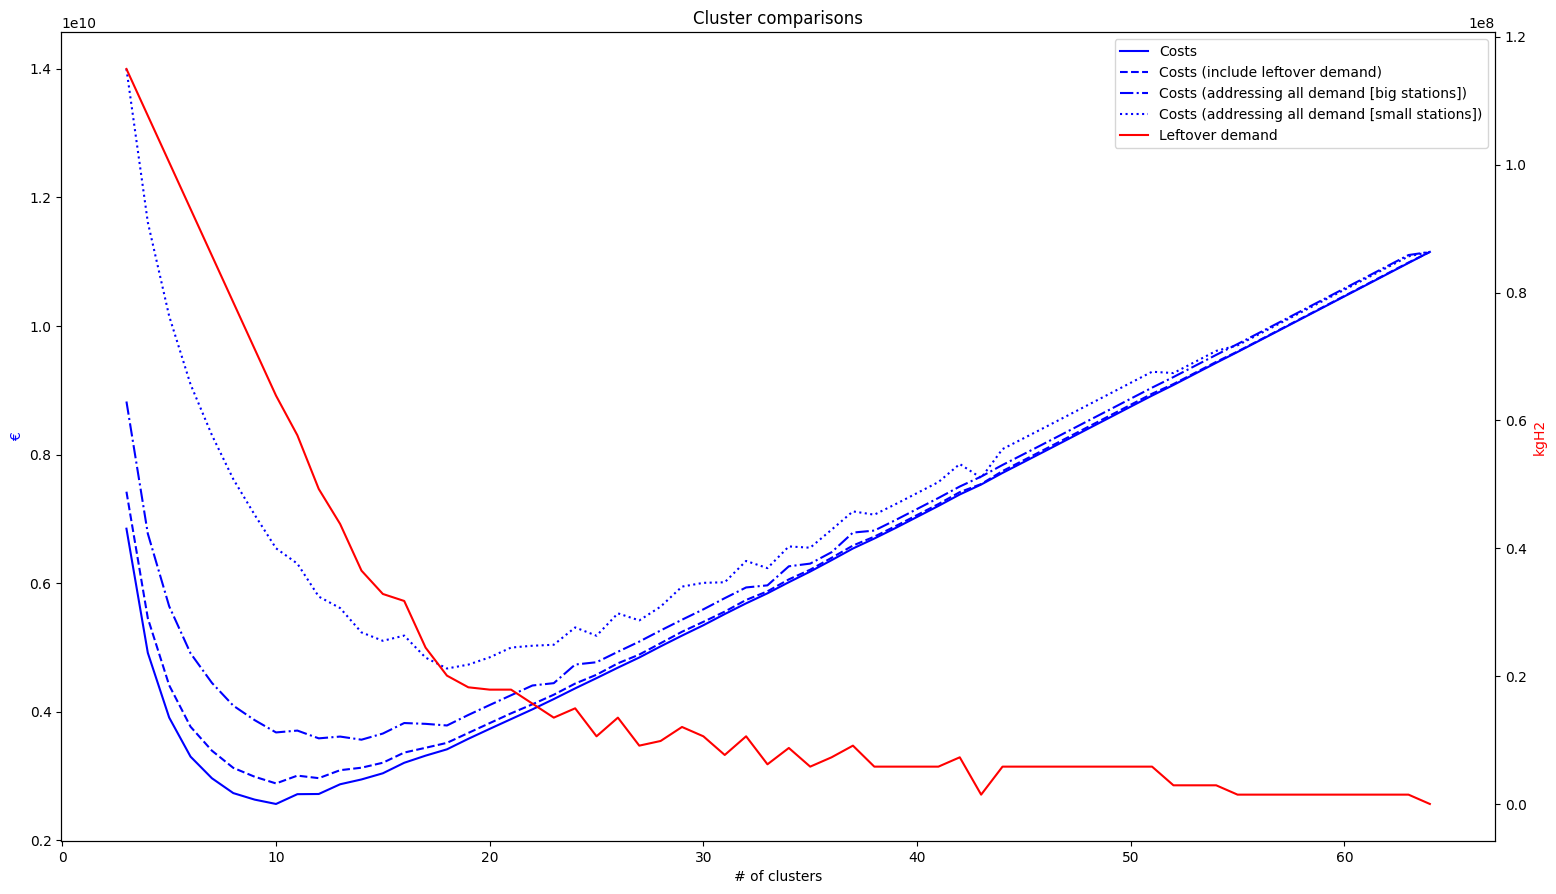

In [307]:
# this part only has to be done when running the entire notebook 
#_, station_demand = plocator.yearly_demand_per_region(final_points_scenario3)
#locations = plocator.combine_demand(station_demand)
# Iterating over all cluster counts to find amount that would reduce costs the most
plocator.visualize_best_cluster(final_points_scenario3, savefile='plot_scenario3.jpg')

In [313]:
# Once we know what the best cluster count is: in this case 12, we can create the locations
production_sites = plocator.clustering_sites(final_points_scenario3, num_production_sites=10)
result = plocator.find_distance_demand(production_sites, final_points_scenario3) # find distance to nearest production site
cost, leftover, production_info = plocator.get_costs(result) # get costs, leftover demand and more production site information
production_sites_scenario3 = pd.concat([production_info, production_sites], axis=1)

In [314]:
from shapely.geometry import Point
def create_point(row):
    return Point(row['longitude'], row['latitude'])

production_sites_scenario3['geometry'] = production_sites_scenario3.apply(create_point, axis=1)
production_sites_scenario2['geometry'] = production_sites_scenario2.apply(create_point, axis=1)
production_sites_scenario1['geometry'] = production_sites_scenario1.apply(create_point, axis=1)

In [315]:
plocator.visualize_on_map(final_points_scenario3, production_sites_scenario3, filename='scenario3part4.html')
plocator.visualize_on_map(final_points_scenario2, production_sites_scenario2, filename='scenario2part4.html')
plocator.visualize_on_map(final_points_scenario1, production_sites_scenario1, filename='scenario1part4.html')


In [316]:
print('Total costs:', production_sites_scenario1[['transport_costs', 'construction_costs']].sum().sum(), 
      'Stations:', production_sites_scenario1['size'].value_counts(), 
      'Average distance:', (production_sites_scenario1.distance_production * production_sites_scenario1[0]).sum()/(production_sites_scenario1[0].sum()))
print('Total costs:', production_sites_scenario2[['transport_costs', 'construction_costs']].sum().sum(), 
      'Stations:', production_sites_scenario2['size'].value_counts(), 
      'Average distance:', (production_sites_scenario2.distance_production * production_sites_scenario2[0]).sum()/(production_sites_scenario2[0].sum()))
print('Total costs:', production_sites_scenario3[['transport_costs', 'construction_costs']].sum().sum(), 
      'Stations:', production_sites_scenario3['size'].value_counts(), 
      'Average distance:', (production_sites_scenario3.distance_production * production_sites_scenario3[0]).sum()/(production_sites_scenario3[0].sum()))

Total costs: 4827435997.345238 Stations: large    18
Name: size, dtype: int64 Average distance: 47.1082836120866
Total costs: 5138212539.451752 Stations: large    13
Name: size, dtype: int64 Average distance: 58.6027796701011
Total costs: 2566145934.5216627 Stations: large    10
Name: size, dtype: int64 Average distance: 70.72581935875318
